# Non-Private Centralized Logistic Regression

In [7]:
# add files that we need!
import os
import sys
import logging 
logger = logging.getLogger()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from src.model.logistic_regression_models import MeanFieldMultiDimensionalLogisticRegression
from src.privacy_accounting.optimizer.standard_optimizer import StandardOptimizer
from src.privacy_accounting.analysis.moment_accountant import compute_privacy_loss_from_ledger


import torch
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# plotting
%matplotlib inline

In [12]:
prior_params = {
    "w_nat_mean": np.array([0.0, 0.0], dtype=np.float32),
    "w_pres": np.array([0.1, 0.1], dtype=np.float32) 
}

# initally local likelihood is zero - init at the prior!
current_params = prior_params 

hyperparameters = {
    "n_in": 2,
    "N_samples": 50,
    "N_steps": 500,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.02},
    "wrapped_optimizer_class": StandardOptimizer,
    "wrapped_optimizer_parameters": {},
    "batch_size": 10
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

In [13]:
data_x = np.array([[2, 2], [1, 1], [0, 1], [1, 0], [-0.5, 0.1], 
                       [-1, -1], [-2, -2], [0, -1], [-1, 0],
                       [0.5, 0.1]], dtype=np.float32)
data_y = np.array([1, 1, 1, 1, 1, -1, -1, -1, -1, -1], dtype=np.float32)

def plot_results(data_x, data_y, opt_params):
    x_vals = data_x[:, 0]
    y_vals = data_x[:, 1]
    labels = data_y
    plt.figure()
    plt.grid(b=True)
    plt.scatter(x_vals, y_vals, c = labels)

    w_map = opt_params['w_nat_mean']/opt_params['w_pres']
    plt.arrow(0, 0, w_map[0], w_map[1], head_width=0.1)
    plt.plot([-2, 2], [(w_map[0]/w_map[1])*2, (w_map[0]/w_map[1])*-2])
    plt.show()
    
def plot_training(training_array):
    x_vals = np.arange(1, training_array.size+1)
    plt.figure()
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()
     
data = {
    "x": data_x,
    "y": data_y,
}

t = {
    "w_nat_mean": np.array([0, 0]),
    "w_pres": np.array([0, 0]) 
}


In [14]:
opt_params = logRegressionModel.fit(data, t, prior_params, hyperparameters)

In [19]:
print(opt_params["w_nat_mean"]/opt_params["w_pres"])

[1.2093844 3.1927102]


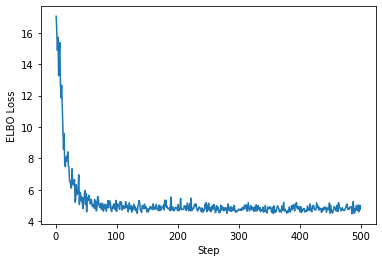

In [15]:
plot_training(logRegressionModel._training_curves[0])

{'w_nat_mean': array([0.8419114, 1.3272331], dtype=float32), 'w_pres': array([0.6998495 , 0.41640985], dtype=float32)}


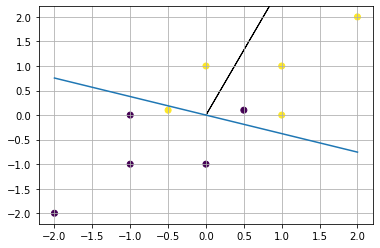

In [7]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

## Let's use DP-SGD Instead!

In [8]:
from src.privacy_accounting.optimizer.dp_optimizer import DPGaussianOptimizer
from src.privacy_accounting.analysis import PrivacyLedger

ledger = PrivacyLedger(data_x.shape[0], 1)

hyperparameters = {
    "n_in": 2,
    "N_samples": 100,
    "N_steps": 10,
    "base_optimizer_class": optim.SGD,
    "base_optimizer_parameters": {'lr': 0.01},
    "wrapped_optimizer_class": DPGaussianOptimizer,
    "wrapped_optimizer_parameters": {
                                     'l2_norm_clip':5.0,
                                     'noise_multiplier': 1,
                                     'num_microbatches': None,
                                     'ledger': ledger,
                                    }
}

logRegressionModel = MeanFieldMultiDimensionalLogisticRegression(current_params, hyperparameters)

/Users/msharma/workspace/DP-PVI/src/utils/torch_nest_utils.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  group_grads.append(operation(*ps))


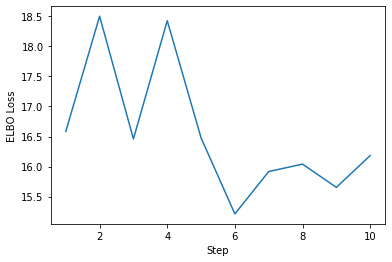

In [18]:
opt_params = logRegressionModel.fit(data, t, prior_params, hyperparameters)
opt_params = logRegressionModel.fit(data, t, prior_params, hyperparameters)
plot_training(logRegressionModel._training_curves[0])

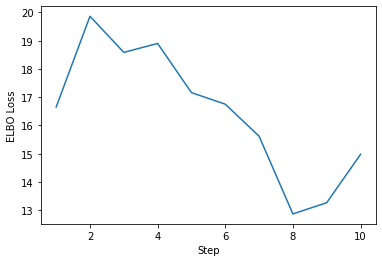

In [10]:
plot_training(logRegressionModel._training_curves[1])

{'w_nat_mean': array([0.0617266 , 0.03901657], dtype=float32), 'w_pres': array([0.20099731, 0.13564356], dtype=float32)}


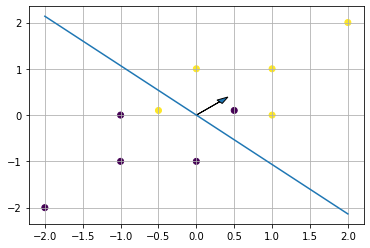

In [11]:
print(opt_params)
plot_results(data_x, data_y, opt_params)

In [15]:
import src.utils.numpy_nest_utils as np_nest

np_nest.structured_ndarrays_to_lists(logRegressionModel.get_incremental_log_record())

In [21]:
logRegressionModel._training_curves

[array([16.585289  , 18.50127411, 16.4605999 , 18.42732811, 16.47747231,
        15.21245861, 15.91738224, 16.04097748, 15.65413094, 16.18267632]),
 array([16.91222954, 19.98900223, 16.02263832, 18.2553463 , 17.9519558 ,
        16.35995483, 15.82911301, 16.78815842, 13.14764595, 16.29333115])]

## How private are we?

Let's compute an $(\epsilon, \delta)$ guarantee. It is required that $\delta << \frac{1}{N} = 0.1$, let's choose $\delta = 10^{-3}$

In [13]:
eps, delta = compute_privacy_loss_from_ledger(ledger.get_formatted_ledger(), 1e-3)

In [14]:
print(eps)

In [42]:
import numpy as np
import collections
import numbers

def structured_lists_to_lists(l):
    ret = []
    for x in l:
        if isinstance(x, list):
            ret.append(structured_lists_to_lists(x))
        elif isinstance(x, dict):
            ret.append(structured_ndarrays_to_lists(x))
        elif isinstance(x, np.ndarray):
            if x.size == 1:
                ret.append(x.tolist()[0])
            else:
                ret.append(x.tolist())
        elif isinstance(x, numbers.Number):
            ret.append(x)
    return ret


def structured_ndarrays_to_lists(d):
    ret = {}
    for k, v in d.items():
        if isinstance(v, collections.MutableMapping):
            ret[k] = structured_ndarrays_to_lists(v)
        elif isinstance(v, np.ndarray):
            if v.size == 1:
                l = v.tolist()
                ret[k] = l[0]
            else:
                ret[k] = v.tolist()
        elif isinstance(v, list):
            # bit of a hack - assume that the list is fine!
            ret[k] = structured_lists_to_lists(v)

    return ret


Given no optimisation has been performed for privacy performance, and the total lack of subsampling, this incredibly weak privacy guarantee is not so surpising. 

In [43]:
ret = {
            "derived_statistics": logRegressionModel._derived_statistics_histories,
            "training_curve": logRegressionModel._training_curves,
        }

In [44]:
structured_ndarrays_to_lists(ret)

{'derived_statistics': [[{'l2_norm:': [1.6456085443496704,
     0.8083175420761108,
     0.6330007314682007,
     0.6330007314682007,
     0.2877309322357178,
     0.9147729873657227,
     1.8789128065109253,
     0.7201851606369019,
     0.7201851606369019,
     0.32201439142227173]},
   {'l2_norm:': [1.9123196601867676,
     0.9366877675056458,
     0.7706707119941711,
     0.7635372281074524,
     0.3436761200428009,
     0.8809979557991028,
     1.7950687408447266,
     0.7318972945213318,
     0.7249066829681396,
     0.3303099274635315]},
   {'l2_norm:': [1.5523715019226074,
     0.7592354416847229,
     0.6054748296737671,
     0.6139677166938782,
     0.28870025277137756,
     0.9474360942840576,
     1.9465135335922241,
     0.7580381035804749,
     0.7694591283798218,
     0.3540652394294739]},
   {'l2_norm:': [1.648261308670044,
     0.8076342344284058,
     0.666602611541748,
     0.6722961068153381,
     0.31775152683258057,
     1.009526252746582,
     2.0728886127471924,